# Transfer Learning for Image Classification

This notebook demonstrates fine-tuning a pre-trained ResNet50 model on the flower102 dataset.

## Overview
- Load pre-trained ResNet50 from PyTorch
- Adapt final layers for flower classification task
- Apply data augmentation
- Train on small dataset (≤10k images)
- Evaluate performance with metrics and visualizations

## 1. Setup and Imports

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, models, transforms
from datasets_utils import FilteredFlowersDataset, mixup_data, mixup_criterion

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tqdm import tqdm
import os
from pathlib import Path
from datetime import datetime

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 2. Configuration

In [ ]:
# Hyperparameters
CONFIG = {
    'batch_size': 8,
    'num_epochs': 20,
    'learning_rate': 0.001, # for final randomly initialized layer
    'fine_tune_lr': 1e-4, # for pre-trained layers during fine-tuning
    'weight_decay': 1e-4, # adds penalty to loss function based on magnitude of weights to prevent overfitting (l2 regularization)
    'label_smoothing': 0.1, # assign slightly lower confidence to true class and distribute rest to other classes to improve generalization
    'mixup_alpha': 0.4, # for synthetic training samples
    'num_classes': 5, # will be overwritten later based on dataset
    'train_split': 0.8, # train split
    'val_split': 0.1,   # validation split
    'test_split': 0.1,  # test split
    'image_size': 224,
    'num_workers': 6,
    'max_classes': 20,  # limit how many Flowers102 classes we train on
}

data_dir = './data'

In [ ]:
# Set up run directories
RUNS_BASE_DIR = Path("./runs")
RUNS_BASE_DIR.mkdir(parents=True, exist_ok=True)

run_start_time = datetime.now()
base_run_name = f"run-{run_start_time.strftime('%Y%m%d-%H%M%S')}"
run_dir_candidate = RUNS_BASE_DIR / base_run_name
suffix = 1
while run_dir_candidate.exists():
    run_dir_candidate = RUNS_BASE_DIR / f"{base_run_name}-{suffix:02d}"
    suffix += 1
RUN_DIR = run_dir_candidate
RUN_DIR.mkdir(parents=True, exist_ok=False)

ARTIFACT_PATHS = {
    'best_model': RUN_DIR / 'best_model.pth',
    'final_model': RUN_DIR / 'transfer_learning_model.pth',
    'training_history': RUN_DIR / 'training_history.png',
    'confusion_matrix': RUN_DIR / 'confusion_matrix.png',
    'confusion_matrix_normalized': RUN_DIR / 'confusion_matrix_normalized.png',
    'misclassifications': RUN_DIR / 'misclassifications.png',
    'per_class_accuracy': RUN_DIR / 'per_class_accuracy.png',
    'changes_log': RUN_DIR / 'changes.md',
}

print(f"Run artifacts will be stored in: {RUN_DIR.resolve()}")

Run artifacts will be stored in: C:\Users\mar20\Desktop\Computer Vision\Image-Classification-With-Transfer-Learning\runs\run-20251125-151512


In [ ]:
def write_changes_markdown(
    output_path: Path,
    *,
    run_name: str,
    run_started_at: datetime,
    config: dict,
    history: dict,
    best_val_acc: float,
    final_val_acc: float,
    misclassified_total: int,
    total_eval_samples: int,
    artifacts: dict,
    train_size: int,
    val_size: int,
    test_size: int = None,
    test_acc: float = None,
) -> None:
    """Persist a markdown log describing what changed during this run."""
    final_train_loss = history['train_loss'][-1] if history['train_loss'] else None
    final_val_loss = history['val_loss'][-1] if history['val_loss'] else None
    final_train_acc = history['train_acc'][-1] if history['train_acc'] else None
    final_val_acc_history = history['val_acc'][-1] if history['val_acc'] else None

    def fmt(value, precision=4):
        return f"{value:.{precision}f}" if value is not None else "N/A"

    def fmt_percent(value, precision=2):
        return f"{value:.{precision}f}%" if value is not None else "N/A"

    config_lines = ["| Key | Value |", "| --- | --- |"]
    for key in sorted(config.keys()):
        config_lines.append(f"| {key} | {config[key]} |")

    artifact_lines = []
    for label, path in artifacts.items():
        if label == 'changes_log':
            continue
        artifact_lines.append(f"- **{label.replace('_', ' ').title()}**: {path.resolve()}")

    markdown = [
        f"# {run_name}",
        "",
        f"- Timestamp: {run_started_at.isoformat()}",
        f"- Device: {device}",
        f"- Training samples: {train_size}",
        f"- Validation samples: {val_size}",
    ]

    if test_size is not None:
        markdown.append(f"- Test samples: {test_size}")

    markdown.extend([
        f"- Best validation accuracy: {best_val_acc:.2f}%",
        f"- Final validation accuracy: {final_val_acc:.2f}%",
    ])

    if test_acc is not None:
        markdown.append(f"- Test accuracy: {test_acc:.2f}%")

    markdown.extend([
        f"- Final train accuracy: {fmt_percent(final_train_acc)}",
        f"- Final val accuracy (from history): {fmt_percent(final_val_acc_history)}",
        f"- Final train loss: {fmt(final_train_loss)}",
        f"- Final val loss: {fmt(final_val_loss)}",
        f"- Misclassifications (Val): {misclassified_total} / {total_eval_samples}",
        "",
        "## Configuration",
        *config_lines,
        "",
        "## Saved Artifacts",
        *(artifact_lines or ["- (no artifacts written)"]),
    ])

    output_path.write_text("\n".join(markdown), encoding="utf-8")
    print(f"Logged run details to {output_path.resolve()}")

## 3. Data Augmentation and Preprocessing

Data augmentation helps prevent overfitting on small datasets by creating variations of training images.

In [42]:
# Data augmentation for training
train_transforms = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])), # Resize images to the specified size for the model.
    transforms.RandomHorizontalFlip(p=0.5), #Randomly flips an image left–right with a 50% chance. Helps the model learn that left/right orientation often doesn't change the class.
    transforms.RandomRotation(15), # Randomly rotates the image by up to 15 degrees. This helps the model become invariant to small rotations.
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Randomly changes the brightness, contrast, saturation, and hue of the image. This helps the model generalize to different lighting conditions.
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # Randomly translates the image by up to 10% of its size. This helps the model become invariant to small translations (doesn't matter where in the image the object is).
    transforms.ToTensor(), # Converts the image to a PyTorch tensor and scales pixel values to [0, 1].
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalizes the image using mean and std values commonly used for pre-trained models.
])

# Validation/test transforms (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])), # Resize images to the specified size for the model.
    transforms.ToTensor(), # Converts the image to a PyTorch tensor and scales pixel values to [0, 1].
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalizes the image using mean and std values commonly used for pre-trained models.
])

print("Data transforms configured successfully")

Data transforms configured successfully


## 4. Load Dataset

We'll use the Flowers102 dataset.

In [ ]:
# Download Flowers102 dataset and keep only a subset of classes
print("Downloading dataset...")
base_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=None)

# Access labels from the dataset (attribute name differs across torchvision versions)
label_source = getattr(base_dataset, '_labels', None) or getattr(base_dataset, 'labels', None)
if label_source is None:
    raise RuntimeError("Unable to read labels from Flowers102 dataset; please update torchvision.")

available_class_count = len(set(label_source))
max_classes = min(CONFIG['max_classes'], available_class_count)
selected_class_ids = list(range(max_classes))
class_mapping = {original: new_idx for new_idx, original in enumerate(selected_class_ids)}
class_names = [f'class_{cls_id}' for cls_id in selected_class_ids]
CONFIG['num_classes'] = len(class_names)

# Gather indices that belong to the selected classes
selected_indices = [idx for idx, label in enumerate(label_source) if label in class_mapping]
if not selected_indices:
    raise RuntimeError("No samples found for the selected class subset.")

# Deterministic shuffle before splitting into train/val/test
rng = np.random.default_rng(42)
rng.shuffle(selected_indices)

total_len = len(selected_indices)
train_size = int(CONFIG['train_split'] * total_len)
val_size = int(CONFIG['val_split'] * total_len)
test_size = total_len - train_size - val_size

train_indices = selected_indices[:train_size]
val_indices = selected_indices[train_size:train_size+val_size]
test_indices = selected_indices[train_size+val_size:]

train_dataset = FilteredFlowersDataset(base_dataset, train_indices, class_mapping, transform=train_transforms)
val_dataset = FilteredFlowersDataset(base_dataset, val_indices, class_mapping, transform=val_transforms)
test_dataset = FilteredFlowersDataset(base_dataset, test_indices, class_mapping, transform=val_transforms)

print(f"Loaded Flowers102 dataset with {len(base_dataset)} total images")
print(f"Using {CONFIG['num_classes']} / {available_class_count} classes")
print(f"Train set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")
print(f"Test set: {len(test_dataset)} images")

Loaded Flowers102 dataset with 1020 total images
Using 20 / 102 classes
Train set: 160 images
Validation set: 40 images


## 5. Create Data Loaders

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"Created data loaders with batch size: {CONFIG['batch_size']}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Created data loaders with batch size: 8
Training batches: 20
Validation batches: 5


## 6. Visualize Sample Images

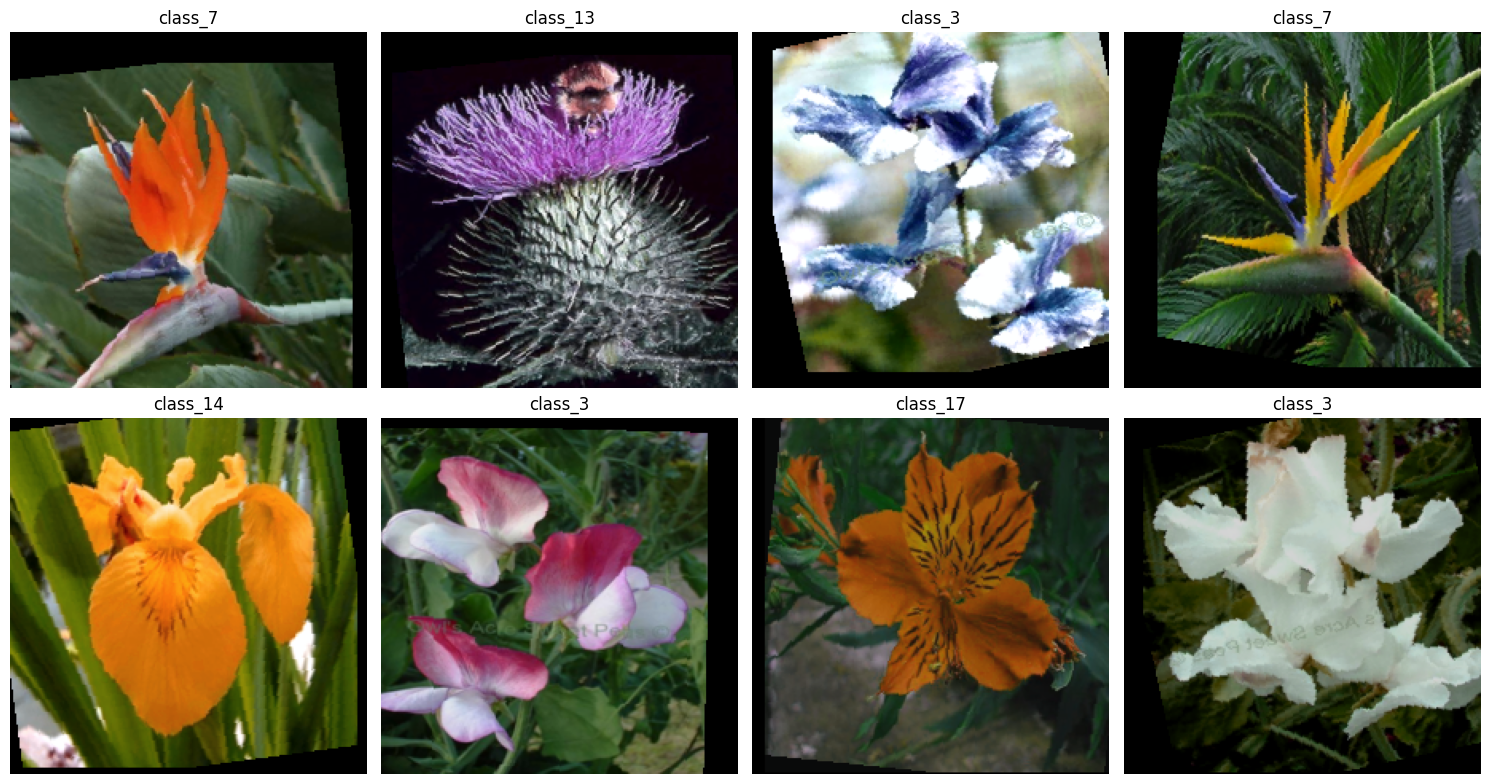

In [45]:
def imshow(img, title=None):
    """Display image with denormalization."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# Get a batch of training data
images, labels = next(iter(train_loader))

# Display first 8 images
fig = plt.figure(figsize=(15, 8))
for idx in range(min(8, len(images))):
    ax = fig.add_subplot(2, 4, idx + 1)
    imshow(images[idx])
    if len(class_names) > labels[idx]:
        ax.set_title(f'{class_names[labels[idx]]}')
    else:
        ax.set_title(f'Class {labels[idx]}')
plt.tight_layout()
plt.show()

## 7. Load Pre-trained Model and Adapt Final Layers

We use ResNet50 pre-trained on ImageNet and modify the final fully connected layer for our specific classification task.

In [ ]:
# Load pre-trained ResNet50 https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

print(f"Original ResNet50 final layer: {model.fc}")

# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

# Replace final fully connected layer
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, CONFIG['num_classes'])
)

# Unfreeze last two ResNet stages for fine-tuning with a small LR
for layer_name in ['layer4']:
    for param in getattr(model, layer_name).parameters():
        param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

print(f"\nModified final layer: {model.fc}")

model = model.to(device)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTrainable parameters: {trainable_params:,} / {total_params:,} ({100*trainable_params/total_params:.2f}%)")

Original ResNet50 final layer: Linear(in_features=2048, out_features=1000, bias=True)

Modified final layer: Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=20, bias=True)
)

Trainable parameters: 16,024,084 / 24,567,380 (65.23%)

Trainable parameters: 16,024,084 / 24,567,380 (65.23%)


## 8. Define Loss Function and Optimizer

In [47]:
criterion = nn.CrossEntropyLoss(label_smoothing=CONFIG['label_smoothing'])
trainable_parameter_groups = [
    {'params': model.fc.parameters(), 'lr': CONFIG['learning_rate']},
    {'params': model.layer4.parameters(), 'lr': CONFIG['fine_tune_lr']},
    {'params': model.layer3.parameters(), 'lr': CONFIG['fine_tune_lr']}
 ]
optimizer = optim.Adam(trainable_parameter_groups, lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")
print(f"Learning rate scheduler: ReduceLROnPlateau")

Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001

Parameter Group 2
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001
)
Learning rate scheduler: ReduceLROnPlateau


### Mixup Helper

## 9. Training Loop

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device, mixup_alpha=0.0):
    model.train()
    running_loss = 0.0
    correct = 0.0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        if mixup_alpha > 0:
            images, targets_a, targets_b, lam = mixup_data(images, labels, mixup_alpha)
            outputs = model(images)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            _, predicted = torch.max(outputs, 1)
            correct_batch = lam * (predicted == targets_a).sum().item()
            correct_batch += (1 - lam) * (predicted == targets_b).sum().item()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            correct_batch = (predicted == labels).sum().item()
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        total += labels.size(0)
        correct += correct_batch
        
        pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [ ]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0

print(f"Starting training for {CONFIG['num_epochs']} epochs...\n")

for epoch in range(CONFIG['num_epochs']):
    print(f"\nEpoch {epoch+1}/{CONFIG['num_epochs']}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc = train_epoch(
        model,
        train_loader,
        criterion,
        optimizer,
        device,
        mixup_alpha=CONFIG['mixup_alpha']
    )
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), ARTIFACT_PATHS['best_model'])
        print(f"Saved best model to {ARTIFACT_PATHS['best_model'].resolve()} (val acc: {val_acc:.2f}%)")

print("\n" + "="*50)
print(f"Training completed! Best validation accuracy: {best_val_acc:.2f}%")
print("="*50)

Starting training for 20 epochs...


Epoch 1/20
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it, loss=2.86, acc=47.5]




Train Loss: 3.0214 | Train Acc: 8.93%
Val Loss: 2.8031 | Val Acc: 47.50%
✓ Saved best model to C:\Users\mar20\Desktop\Computer Vision\Image-Classification-With-Transfer-Learning\runs\run-20251125-151512\best_model.pth (val acc: 47.50%)

Epoch 2/20
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it, loss=2.29, acc=62.5]




Train Loss: 2.6326 | Train Acc: 35.05%
Val Loss: 2.2133 | Val Acc: 62.50%
✓ Saved best model to C:\Users\mar20\Desktop\Computer Vision\Image-Classification-With-Transfer-Learning\runs\run-20251125-151512\best_model.pth (val acc: 62.50%)

Epoch 3/20
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it, loss=1.47, acc=77.5]




Train Loss: 1.9447 | Train Acc: 62.63%
Val Loss: 1.4443 | Val Acc: 77.50%
✓ Saved best model to C:\Users\mar20\Desktop\Computer Vision\Image-Classification-With-Transfer-Learning\runs\run-20251125-151512\best_model.pth (val acc: 77.50%)

Epoch 4/20
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:06<00:00,  1.36s/it, loss=1.34, acc=80]  




Train Loss: 1.6264 | Train Acc: 68.60%
Val Loss: 1.2392 | Val Acc: 80.00%
✓ Saved best model to C:\Users\mar20\Desktop\Computer Vision\Image-Classification-With-Transfer-Learning\runs\run-20251125-151512\best_model.pth (val acc: 80.00%)

Epoch 5/20
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it, loss=1.44, acc=75]



Train Loss: 1.3951 | Train Acc: 77.82%
Val Loss: 1.2229 | Val Acc: 75.00%

Epoch 6/20
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it, loss=1.16, acc=82.5] 




Train Loss: 1.4904 | Train Acc: 72.69%
Val Loss: 1.0968 | Val Acc: 82.50%
✓ Saved best model to C:\Users\mar20\Desktop\Computer Vision\Image-Classification-With-Transfer-Learning\runs\run-20251125-151512\best_model.pth (val acc: 82.50%)

Epoch 7/20
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it, loss=1.37, acc=85]   




Train Loss: 1.3542 | Train Acc: 81.48%
Val Loss: 1.1179 | Val Acc: 85.00%
✓ Saved best model to C:\Users\mar20\Desktop\Computer Vision\Image-Classification-With-Transfer-Learning\runs\run-20251125-151512\best_model.pth (val acc: 85.00%)

Epoch 8/20
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it, loss=1.24, acc=85]



Train Loss: 1.2369 | Train Acc: 83.58%
Val Loss: 1.0357 | Val Acc: 85.00%

Epoch 9/20
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it, loss=1.19, acc=90]   




Train Loss: 1.2656 | Train Acc: 83.70%
Val Loss: 1.0256 | Val Acc: 90.00%
✓ Saved best model to C:\Users\mar20\Desktop\Computer Vision\Image-Classification-With-Transfer-Learning\runs\run-20251125-151512\best_model.pth (val acc: 90.00%)

Epoch 10/20
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it, loss=1.12, acc=87.5]



Train Loss: 1.0184 | Train Acc: 90.31%
Val Loss: 0.9976 | Val Acc: 87.50%

Epoch 11/20
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it, loss=1.18, acc=90]



Train Loss: 1.2878 | Train Acc: 84.29%
Val Loss: 0.9799 | Val Acc: 90.00%

Epoch 12/20
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it, loss=1.28, acc=85]



Train Loss: 1.3137 | Train Acc: 82.11%
Val Loss: 1.0728 | Val Acc: 85.00%

Epoch 13/20
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it, loss=1.21, acc=90]



Train Loss: 1.2663 | Train Acc: 84.58%
Val Loss: 1.0344 | Val Acc: 90.00%

Epoch 14/20
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it, loss=1.22, acc=87.5]



Train Loss: 1.3175 | Train Acc: 81.92%
Val Loss: 1.0537 | Val Acc: 87.50%

Epoch 15/20
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it, loss=1.22, acc=87.5]



Train Loss: 1.0923 | Train Acc: 88.71%
Val Loss: 1.0795 | Val Acc: 87.50%

Epoch 16/20
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it, loss=1.13, acc=90]



Train Loss: 1.2476 | Train Acc: 83.41%
Val Loss: 0.9717 | Val Acc: 90.00%

Epoch 17/20
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it, loss=1.17, acc=85]



Train Loss: 1.2050 | Train Acc: 84.44%
Val Loss: 1.0039 | Val Acc: 85.00%

Epoch 18/20
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it, loss=1.02, acc=92.5] 




Train Loss: 1.1837 | Train Acc: 83.26%
Val Loss: 0.9300 | Val Acc: 92.50%
✓ Saved best model to C:\Users\mar20\Desktop\Computer Vision\Image-Classification-With-Transfer-Learning\runs\run-20251125-151512\best_model.pth (val acc: 92.50%)

Epoch 19/20
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it, loss=1.04, acc=85]



Train Loss: 1.1118 | Train Acc: 87.77%
Val Loss: 0.9700 | Val Acc: 85.00%

Epoch 20/20
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it, loss=1.25, acc=87.5] 


Train Loss: 1.1045 | Train Acc: 88.09%
Val Loss: 1.0508 | Val Acc: 87.50%

Training completed! Best validation accuracy: 92.50%


## 10. Visualize Training History

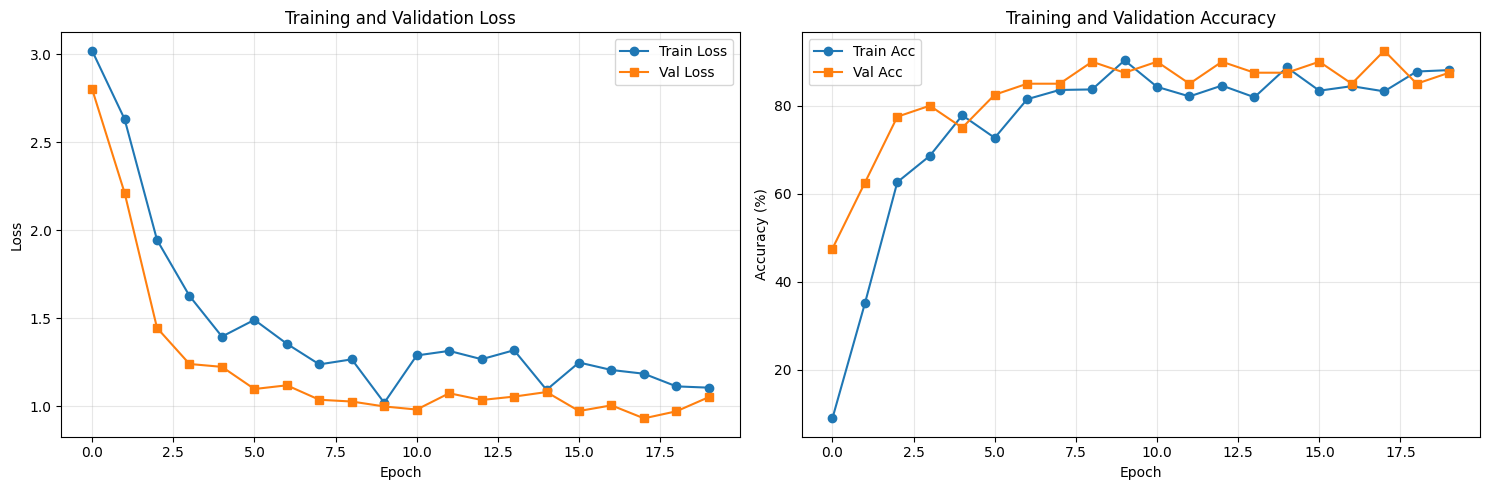

Saved training curves to C:\Users\mar20\Desktop\Computer Vision\Image-Classification-With-Transfer-Learning\runs\run-20251125-151512\training_history.png


In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(history['train_acc'], label='Train Acc', marker='o')
ax2.plot(history['val_acc'], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(ARTIFACT_PATHS['training_history'], dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved training curves to {ARTIFACT_PATHS['training_history'].resolve()}")

## 11. Load Best Model and Evaluate

In [51]:
# Load best model
model.load_state_dict(torch.load(ARTIFACT_PATHS['best_model']))
model.eval()

print(f"Loaded best model from {ARTIFACT_PATHS['best_model'].resolve()} for evaluation")

Loaded best model from C:\Users\mar20\Desktop\Computer Vision\Image-Classification-With-Transfer-Learning\runs\run-20251125-151512\best_model.pth for evaluation


## 12. Generate Predictions and Calculate Metrics

In [ ]:
def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Predicting'):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

# Get predictions
predictions, true_labels, probabilities = get_predictions(model, val_loader, device)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"\nValidation Accuracy: {accuracy * 100:.2f}%")

Predicting: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


Validation Accuracy: 92.50%


## 13. Confusion Matrix

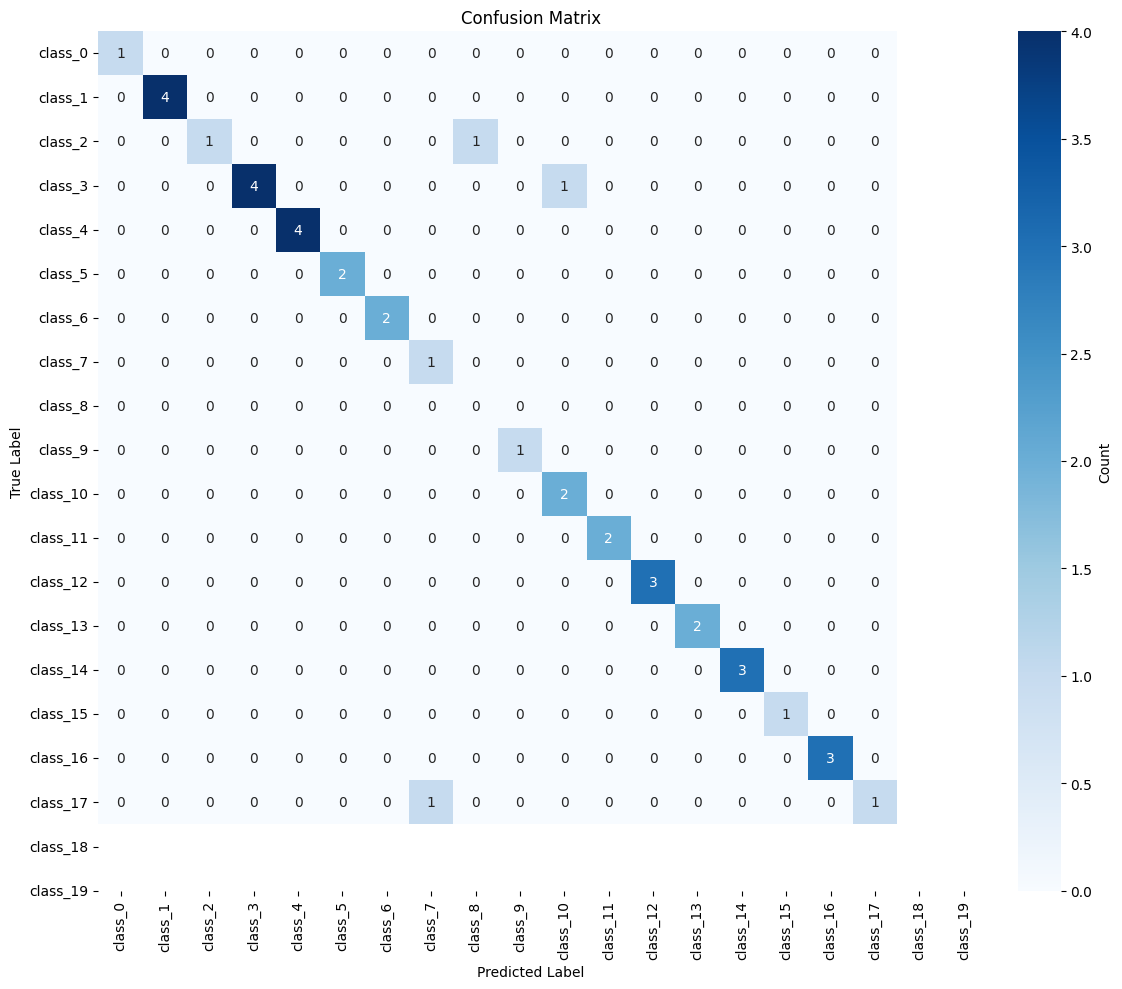

C:\Users\mar20\AppData\Local\Temp\ipykernel_16164\504565054.py:18: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


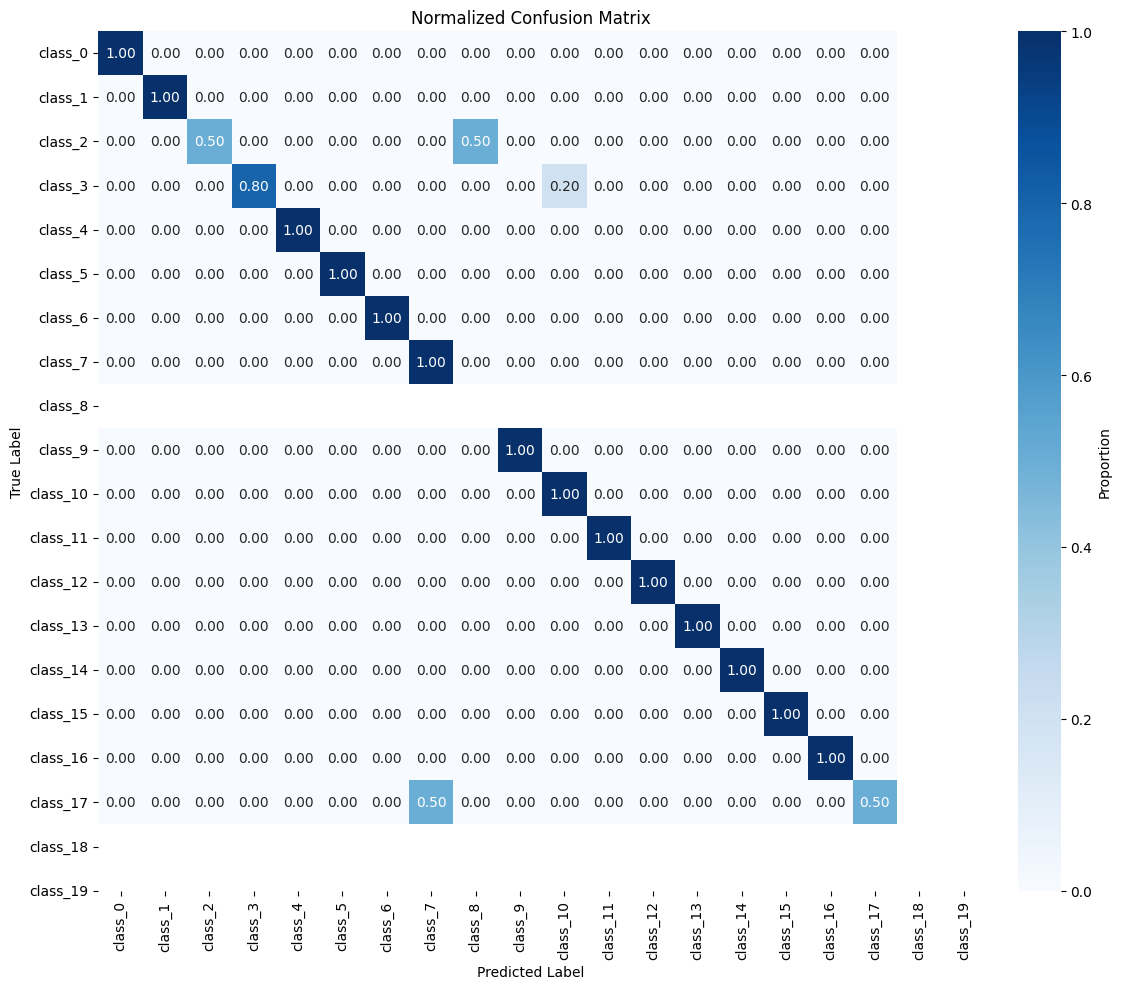

Saved confusion matrix figures to:
  - C:\Users\mar20\Desktop\Computer Vision\Image-Classification-With-Transfer-Learning\runs\run-20251125-151512\confusion_matrix.png
  - C:\Users\mar20\Desktop\Computer Vision\Image-Classification-With-Transfer-Learning\runs\run-20251125-151512\confusion_matrix_normalized.png


In [53]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names[:CONFIG['num_classes']], 
            yticklabels=class_names[:CONFIG['num_classes']],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig(ARTIFACT_PATHS['confusion_matrix'], dpi=300, bbox_inches='tight')
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names[:CONFIG['num_classes']], 
            yticklabels=class_names[:CONFIG['num_classes']],
            cbar_kws={'label': 'Proportion'})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.savefig(ARTIFACT_PATHS['confusion_matrix_normalized'], dpi=300, bbox_inches='tight')
plt.show()

print("Saved confusion matrix figures to:")
print(f"  - {ARTIFACT_PATHS['confusion_matrix'].resolve()}")
print(f"  - {ARTIFACT_PATHS['confusion_matrix_normalized'].resolve()}")

## 14. Classification Report

In [54]:
# Generate classification report
print("\nClassification Report:")
print("=" * 70)
report = classification_report(
    true_labels, 
    predictions, 
    target_names=class_names[:CONFIG['num_classes']],
    digits=4
)
print(report)


Classification Report:


ValueError: Number of classes, 18, does not match size of target_names, 20. Try specifying the labels parameter

## 15. Analyze Misclassifications

Let's examine cases where the model made incorrect predictions.

In [55]:
# Find misclassified samples
misclassified_indices = np.where(predictions != true_labels)[0]
print(f"Total misclassifications: {len(misclassified_indices)} / {len(true_labels)} ({100*len(misclassified_indices)/len(true_labels):.2f}%)")

# Get confidence scores for misclassifications
misclassified_confidences = []
for idx in misclassified_indices:
    pred_class = predictions[idx]
    confidence = probabilities[idx][pred_class]
    misclassified_confidences.append(confidence)

print(f"\nAverage confidence in wrong predictions: {np.mean(misclassified_confidences):.4f}")
print(f"Min confidence: {np.min(misclassified_confidences):.4f}")
print(f"Max confidence: {np.max(misclassified_confidences):.4f}")

Total misclassifications: 3 / 40 (7.50%)

Average confidence in wrong predictions: 0.5708
Min confidence: 0.5154
Max confidence: 0.6071


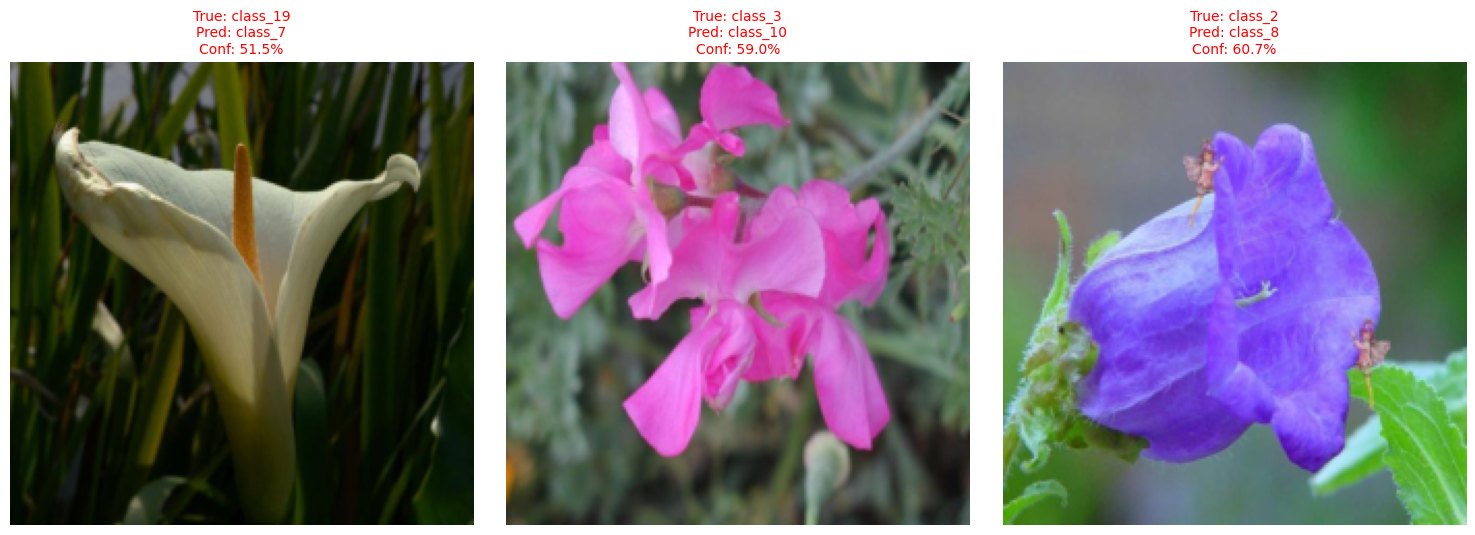

Saved misclassification grid to C:\Users\mar20\Desktop\Computer Vision\Image-Classification-With-Transfer-Learning\runs\run-20251125-151512\misclassifications.png


In [56]:
# Visualize misclassified samples
def visualize_misclassifications(dataset, indices, predictions, true_labels, probabilities, class_names, num_samples=12):
    """Visualize misclassified samples."""
    num_samples = min(num_samples, len(indices))
    if num_samples == 0:
        print("No misclassifications to display!")
        return
    
    # Select random misclassified samples
    selected_indices = np.random.choice(indices, size=num_samples, replace=False)
    
    fig = plt.figure(figsize=(20, 15))
    for i, idx in enumerate(selected_indices):
        # Get image
        img, _ = dataset[idx]
        
        pred_class = predictions[idx]
        true_class = true_labels[idx]
        confidence = probabilities[idx][pred_class] * 100
        
        ax = fig.add_subplot(3, 4, i + 1)
        imshow(img)
        
        # Create title with prediction info
        true_name = class_names[true_class] if true_class < len(class_names) else f'Class {true_class}'
        pred_name = class_names[pred_class] if pred_class < len(class_names) else f'Class {pred_class}'
        
        ax.set_title(
            f'True: {true_name}\nPred: {pred_name}\nConf: {confidence:.1f}%',
            fontsize=10, color='red'
        )
    
    plt.tight_layout()
    plt.savefig(ARTIFACT_PATHS['misclassifications'], dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved misclassification grid to {ARTIFACT_PATHS['misclassifications'].resolve()}")

# Visualize misclassifications
visualize_misclassifications(
    val_dataset,
    misclassified_indices,
    predictions,
    true_labels,
    probabilities,
    class_names,
    num_samples=12
)

## 16. Per-Class Performance Analysis

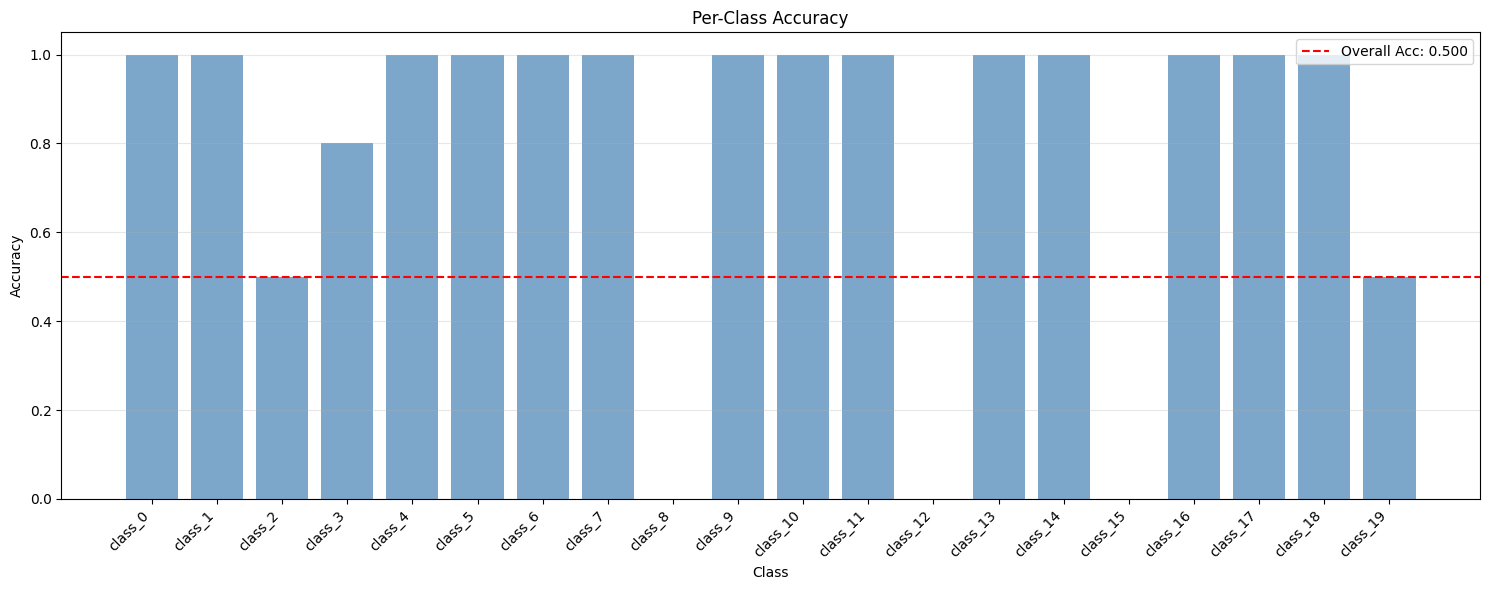

Saved per-class accuracy chart to C:\Users\mar20\Desktop\Computer Vision\Image-Classification-With-Transfer-Learning\runs\run-20251125-151512\per_class_accuracy.png

Per-Class Performance:
class_0                  : 100.00% (  1/  1)
class_1                  : 100.00% (  4/  4)
class_2                  :  50.00% (  1/  2)
class_3                  :  80.00% (  4/  5)
class_4                  : 100.00% (  4/  4)
class_5                  : 100.00% (  2/  2)
class_6                  : 100.00% (  2/  2)
class_7                  : 100.00% (  1/  1)
class_8                  :   0.00% (  0/  0)
class_9                  : 100.00% (  1/  1)
class_10                 : 100.00% (  2/  2)
class_11                 : 100.00% (  2/  2)
class_12                 :   0.00% (  0/  0)
class_13                 : 100.00% (  3/  3)
class_14                 : 100.00% (  2/  2)
class_15                 :   0.00% (  0/  0)
class_16                 : 100.00% (  3/  3)
class_17                 : 100.00% (  1/  1)
c

In [ ]:
# Calculate per-class accuracy
per_class_correct = []
per_class_total = []
per_class_acc = []

for class_idx in range(CONFIG['num_classes']):
    class_mask = true_labels == class_idx
    class_preds = predictions[class_mask]
    class_true = true_labels[class_mask]
    
    correct = np.sum(class_preds == class_true)
    total = len(class_true)
    class_acc = correct / total if total > 0 else 0
    
    per_class_correct.append(correct)
    per_class_total.append(total)
    per_class_acc.append(class_acc)

# Plot per-class accuracy
plt.figure(figsize=(15, 6))
x_pos = np.arange(CONFIG['num_classes'])
plt.bar(x_pos, per_class_acc, alpha=0.7, color='steelblue')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.xticks(x_pos, [class_names[i] if i < len(class_names) else f'C{i}' for i in range(CONFIG['num_classes'])], rotation=45, ha='right')
plt.axhline(y=accuracy, color='r', linestyle='--', label=f'Overall Acc: {accuracy:.3f}')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(ARTIFACT_PATHS['per_class_accuracy'], dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved per-class accuracy chart to {ARTIFACT_PATHS['per_class_accuracy'].resolve()}")

# Print summary
print("\nPer-Class Performance:")
print("=" * 70)
for i in range(CONFIG['num_classes']):
    class_name = class_names[i] if i < len(class_names) else f'Class {i}'
    print(f"{class_name:25s}: {per_class_acc[i]*100:6.2f}% ({per_class_correct[i]:3d}/{per_class_total[i]:3d})")

In [ ]:
print("\n" + "="*70)
print("TEST SET EVALUATION")
print("="*70)

# Get predictions on test set
test_predictions, test_true_labels, test_probabilities = get_predictions(model, test_loader, device)

# Calculate accuracy
test_accuracy = accuracy_score(test_true_labels, test_predictions)
print(f"\nTest Set Accuracy: {test_accuracy * 100:.2f}%")

# Generate classification report for test set
print("\nTest Set Classification Report:")
print("-" * 70)
test_report = classification_report(
    test_true_labels, 
    test_predictions, 
    target_names=class_names[:CONFIG['num_classes']],
    digits=4
)
print(test_report)

## 17. Test Set Evaluation

Evaluate the best model on the held-out test set.

## 17. Model Summary and Statistics

In [ ]:
print("\n" + "="*70)
print("MODEL SUMMARY")
print("="*70)
print(f"Architecture: ResNet50 (Transfer Learning)")
print(f"Pre-trained on: ImageNet")
print(f"Fine-tuned for: {CONFIG['num_classes']} classes")
print(f"\nDataset Size:")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")
print(f"  Test samples: {len(test_dataset)}")
print(f"\nTraining Configuration:")
print(f"  Epochs: {CONFIG['num_epochs']}")
print(f"  Batch size: {CONFIG['batch_size']}")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  Optimizer: Adam")
print(f"  Loss function: CrossEntropyLoss")
print(f"\nModel Parameters:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,} ({100*trainable_params/total_params:.2f}%)")
print(f"\nPerformance:")
print(f"  Best validation accuracy: {best_val_acc:.2f}%")
print(f"  Final validation accuracy: {accuracy * 100:.2f}%")
print(f"  Test accuracy: {test_accuracy * 100:.2f}%")
print(f"  Total misclassifications (Val): {len(misclassified_indices)} / {len(true_labels)}")
print("="*70)


MODEL SUMMARY
Architecture: ResNet50 (Transfer Learning)
Pre-trained on: ImageNet
Fine-tuned for: 20 classes

Dataset Size:
  Training samples: 160
  Validation samples: 40

Training Configuration:
  Epochs: 20
  Batch size: 8
  Learning rate: 0.001
  Optimizer: Adam
  Loss function: CrossEntropyLoss

Model Parameters:
  Total parameters: 24,567,380
  Trainable parameters: 16,024,084 (65.23%)

Performance:
  Best validation accuracy: 92.50%
  Final validation accuracy: 50.00%
  Total misclassifications: 3 / 40


## 18. Save Model and Results

In [59]:
# Save final model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'config': CONFIG,
    'class_names': class_names,
    'history': history,
    'best_val_acc': best_val_acc
}, ARTIFACT_PATHS['final_model'])

print("Model and training history saved successfully!")
print("\nSaved files:")
print(f"  - {ARTIFACT_PATHS['best_model'].resolve()}")
print(f"  - {ARTIFACT_PATHS['final_model'].resolve()}")
print(f"  - {ARTIFACT_PATHS['training_history'].resolve()}")
print(f"  - {ARTIFACT_PATHS['confusion_matrix'].resolve()}")
print(f"  - {ARTIFACT_PATHS['confusion_matrix_normalized'].resolve()}")
print(f"  - {ARTIFACT_PATHS['misclassifications'].resolve()}")
print(f"  - {ARTIFACT_PATHS['per_class_accuracy'].resolve()}")

Model and training history saved successfully!

Saved files:
  - C:\Users\mar20\Desktop\Computer Vision\Image-Classification-With-Transfer-Learning\runs\run-20251125-151512\best_model.pth
  - C:\Users\mar20\Desktop\Computer Vision\Image-Classification-With-Transfer-Learning\runs\run-20251125-151512\transfer_learning_model.pth
  - C:\Users\mar20\Desktop\Computer Vision\Image-Classification-With-Transfer-Learning\runs\run-20251125-151512\training_history.png
  - C:\Users\mar20\Desktop\Computer Vision\Image-Classification-With-Transfer-Learning\runs\run-20251125-151512\confusion_matrix.png
  - C:\Users\mar20\Desktop\Computer Vision\Image-Classification-With-Transfer-Learning\runs\run-20251125-151512\confusion_matrix_normalized.png
  - C:\Users\mar20\Desktop\Computer Vision\Image-Classification-With-Transfer-Learning\runs\run-20251125-151512\misclassifications.png
  - C:\Users\mar20\Desktop\Computer Vision\Image-Classification-With-Transfer-Learning\runs\run-20251125-151512\per_class_accur

In [ ]:
run_name = RUN_DIR.name

write_changes_markdown(
    ARTIFACT_PATHS['changes_log'],
    run_name=run_name,
    run_started_at=run_start_time,
    config=CONFIG,
    history=history,
    best_val_acc=best_val_acc,
    final_val_acc=accuracy * 100,
    misclassified_total=len(misclassified_indices),
    total_eval_samples=len(true_labels),
    artifacts=ARTIFACT_PATHS,
    train_size=len(train_dataset),
    val_size=len(val_dataset),
    test_size=len(test_dataset),
    test_acc=test_accuracy * 100
)

Logged run details to C:\Users\mar20\Desktop\Computer Vision\Image-Classification-With-Transfer-Learning\runs\run-20251125-151512\changes.md


## Summary

This notebook demonstrated:
1. **Loading a pre-trained model**: Used ResNet50 pre-trained on ImageNet
2. **Transfer learning**: Froze convolutional layers and trained only final classifier
3. **Data augmentation**: Applied transformations to increase training data diversity
4. **Training**: Fine-tuned model on custom dataset
5. **Evaluation**: Comprehensive metrics including accuracy, confusion matrix, and misclassification analysis

### Key Observations
- Transfer learning allows achieving good performance with limited data
- Pre-trained features from ImageNet generalize well to many vision tasks
- Data augmentation helps prevent overfitting on small datasets
- Only training final layers is computationally efficient